# Project 2 - Term Deposit Marketing

**Goal(s):**

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, in this case to ensure a term deposit subscription. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. 

The firm is looking for ways to improve the success rate for calls made to customers; which is why the objective is to predict if the customer they are calling will subscribe or not (yes/no) to a term deposit (variable y).

Attributes:

- age : age of customer (numeric)
- job : type of job (categorical)
- marital : marital status (categorical)
- education (categorical)
- default: has credit in default? (binary)
- balance: average yearly balance, in euros (numeric)
- housing: has a housing loan? (binary)
- loan: has personal loan? (binary)
- contact: contact communication type (categorical)
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical)
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)

**Results:**

# TODO

## Analysis

In [1]:
os.chdir('/home/alexandrabinder/Projects/Apziva/')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import get_percent

PROJECT_PATH = os.path.join(os.getcwd(),'p2-term-deposit-marketing')

In [2]:
file_name = 'term-deposit-marketing-2020.csv'
df = pd.read_csv(os.path.join(PROJECT_PATH, file_name))
df = df.rename({'y': 'Y'}, axis=1)

print(f'[DATA SIZE] {df.shape[0]} data with {df.shape[1]-1} attributes\n')

feature_names = df.columns
print(feature_names)

display(df.head())

[DATA SIZE] 40000 data with 13 attributes

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'Y'],
      dtype='object')


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,Y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


### Target feature

First lets check if our target variable is balanced or not and if it is imbalanced, for how much. This will allow us to know what measures to take in case of un unbalanced class problem.

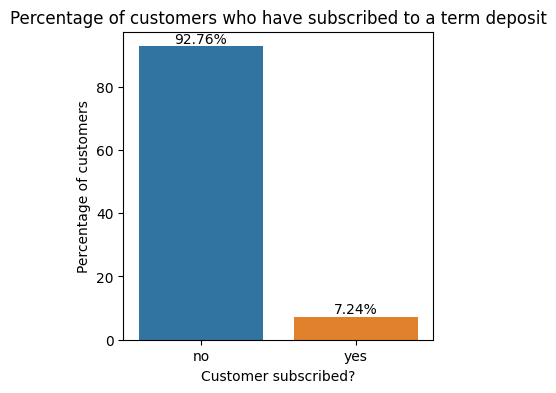

In [3]:
df1 = df['Y'].value_counts(normalize=True)
df1 = df1.mul(100)

fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.barplot(x=df1.index, y=df1.values, orient='v', ax=ax).set(xlabel='Customer subscribed?',
                                                                ylabel='Percentage of customers',
                                                                title='Percentage of customers who have subscribed to a term deposit');
ax.bar_label(ax.containers[0], fmt='%.2f%%');

The target value is umbalanced in a proportion of 12.81% where our class of interest (`yes` class) is lacking data. We will have to treat this problem further on.

In the mean time, let's explore the rest of the data and check for missing values and/or outliers.

### Attributes

In [4]:
true_mask = [True]*df.shape[0]
subscribed_mask = df['Y'] == 'yes'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  Y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


No null values are observed in the dataset.

We observe that we have 5 numeric attributes and 8 categorical attributes. Lets analyse them separately.

In [5]:
cat_cols, num_cols = [], []
[cat_cols.append(col) if df[col].dtype == 'object' else num_cols.append(col) for col in df.columns[0:-1]];
print(f"{len(num_cols)} numeric attributes {num_cols}\n{len(cat_cols)} categorical attributes {cat_cols}")

5 numeric attributes ['age', 'balance', 'day', 'duration', 'campaign']
8 categorical attributes ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']


#### Numeric attributes

In [6]:
df_numeric = df[num_cols]
df_numeric.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


At first glance we get the following information for each of the numerical attributes:
- `age`: minimum and maximum values are between the expected range (population between the ages of 19 and 95). The mean indicates that the population tends to be around 40 years old.
- `balance`: the minimum value is negative; further exploration is in place to analyse if this is a regular situation or not.
- `day`: minimum and maximum values are between the expected range (1 and 31)
- `duration`: the minimum value appears to be 0 seconds; further exploration is in place to quantify how recurrent is this situation
- `campaign`: the maximum values is off bounds with that seen in Q3; further exporation is in place to check if there are any outliers

A quick analysis for each attribute will be made using a graph that combines both a distribution plot and a box plot. For the latter lines will be traced that represent the caps, quartiles, min, max and mean values for each distribution.

In [15]:
def plot_distribution_with_stats(df, col, graph=True, lines=True):
    bp = plt.boxplot(df[col], vert=False, widths=5);
    plt.close()
    stats = dict()
    for key in ['caps', 'boxes', 'medians']:
        stats[key] = [item.get_xdata() for item in bp[key]]

    aux = pd.DataFrame({'min': df[col].min(),
                        'left cap': stats['caps'][0][0], 
                        'Q1': stats['boxes'][0][0],
                        'Q2': stats['medians'][0][0],
                        'Q3': stats['boxes'][0][2],
                        'right cap': stats['caps'][1][0],
                        'max': df[col].max(),
                        'mean': df[col].mean(),
                        'mode': df[col].mode()
                        }, index=[0])

    if graph:
        title = col[0].upper()+col[1::]
        fig, ax = plt.subplots(1,1, figsize=(10,3))
        fig.suptitle(title)

        sns.histplot(df[col], kde=True, ax=ax).set(xlabel=title, ylabel='frequency');

        if lines:
            plt.axvline(aux.loc[0,'min'], 0,1, color='black', linestyle='--');
            plt.axvline(aux.loc[0,'left cap'], 0,1, color='red', linestyle='--');
            plt.axvline(aux.loc[0,'Q1'], 0,1, color='green', linestyle='--');
            plt.axvline(aux.loc[0,'Q2'], 0,1, color='green', linestyle='--');
            plt.axvline(aux.loc[0,'mean'], 0,1, color='purple', linestyle='--');
            plt.axvline(aux.loc[0,'Q3'], 0,1, color='green', linestyle='--');
            plt.axvline(aux.loc[0,'right cap'], 0,1, color='red', linestyle='--');
            plt.axvline(aux.loc[0,'max'], 0,1, color='black', linestyle='--');

            plt.legend(['distribution', 'min', 'left cap', 'Q1', 'Q2', 'mean', 'Q3', 'right cap', 'max'], bbox_to_anchor=(1.01, 1));

        plt.show()

    if lines: display(aux)

    return aux

##### Age

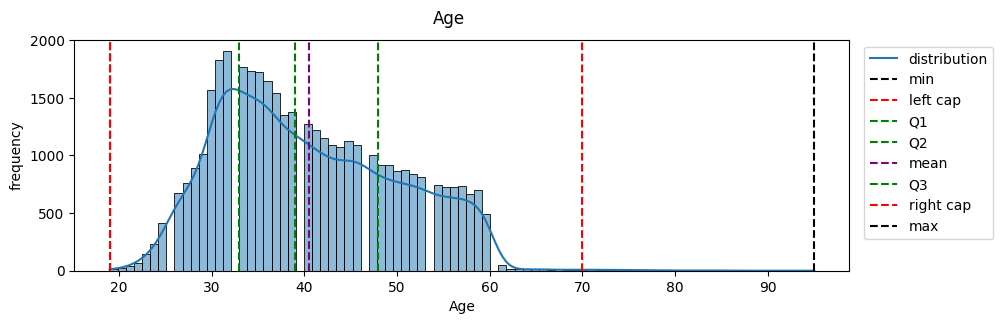

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,19,19,33.0,39.0,48.0,70,95,40.5446,32


In [10]:
aux = plot_distribution_with_stats(df, 'age')

In [9]:
case_mask = df['age'] > aux.loc[0,'right cap']

print(f'People older than 70 years old appear as outliers, they make up for {get_percent(df, case_mask, df, true_mask)}% of the data')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

People older than 70 years old appear as outliers, they make up for 0.2% of the data
From those people 46.84% (37 entries) subscribed to a term deposit. They represent 0.09% from total.


As mentioned before the minimum and maximum values are between the expected range (population between the ages of 19 and 95). The mean indicates that the population tends to be arround 40 years old. This is confirmed through the graph where they highest frequencies lie around people between 20 and 60 years old.

##### Balance

We had seen before that the balance attribute had negative values. Lets check in how many cases does this happen.

In [10]:
case_mask = df['balance'] < 0

print(f'Negative balance values make up for {get_percent(df, case_mask, df, true_mask)}% of the data')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

case_mask = df['balance'] == 0

print(f'\n$0 balance values make up for {get_percent(df, case_mask, df, true_mask)}% of the data')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

case_mask = df['balance'] > 0

print(f'\nPositive balance values make up for {get_percent(df, case_mask, df, true_mask)}% of the data')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

Negative balance values make up for 9.33% of the data
From those people 5.28% (197 entries) subscribed to a term deposit. They represent 0.49% from total.

$0 balance values make up for 8.02% of the data
From those people 5.58% (179 entries) subscribed to a term deposit. They represent 0.45% from total.

Positive balance values make up for 82.65% of the data
From those people 7.62% (2520 entries) subscribed to a term deposit. They represent 6.3% from total.


We conclude that even though it is more common tu find a positive balance, $0 and negative balances are also possible.

Lets analyse the distribution:

In [13]:
aux = plot_distribution_with_stats(df, 'balance', graph=False)

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,-8019,-1818,54.0,407.0,1319.0,3216,102127,1274.27755,0


Results show that there are outliers on both lower and upper bounds; lets quantify how many on each side and then plot the distribution graph eliminating the outliers to get a closer look at the distribution:

0.06% (24 entries) of the data are lower bound outliers
From these cases 8.33% (2 entries) subscribed to a term deposit. They represent 0.0% from total.

10.65% (4259 entries) of the data are upper bound outliers
From these cases 10.07% (429 entries) subscribed to a term deposit. They represent 1.07% from total.


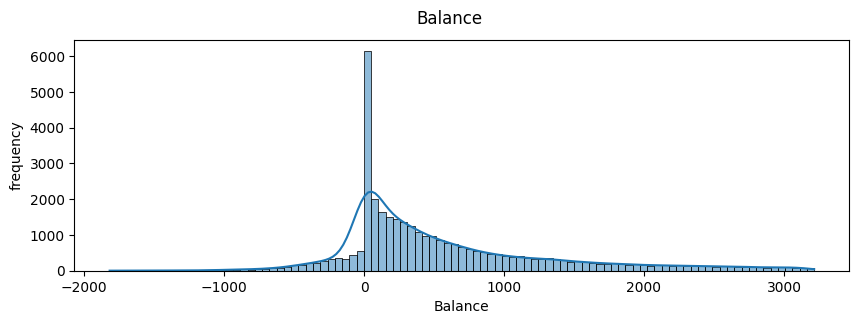

In [16]:
case_mask = df['balance'] <= aux.loc[0, 'left cap']

print(f'{get_percent(df, case_mask, df, true_mask)}% ({df[case_mask].shape[0]} entries) of the data are lower bound outliers')
print(f'From these cases {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

case_mask = df['balance'] >= aux.loc[0, 'right cap']

print(f'\n{get_percent(df, case_mask, df, true_mask)}% ({df[case_mask].shape[0]} entries) of the data are upper bound outliers')
print(f'From these cases {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

mask = (df['balance'] >= aux.loc[0, 'left cap']) & (df['balance'] <= aux.loc[0, 'right cap'])
plot_distribution_with_stats(df[mask], 'balance', lines=False);

It draws to our attention the peak in frequency near the $0 balance. Taking into account that the bins have a size of 50. It is expected for people to have balances between $0-$50.

In summary, balance values are behaving as expected.

##### Day

PEOPLE WHO HAVE SUBSCRIBED TO A TERM DEPOSIT:


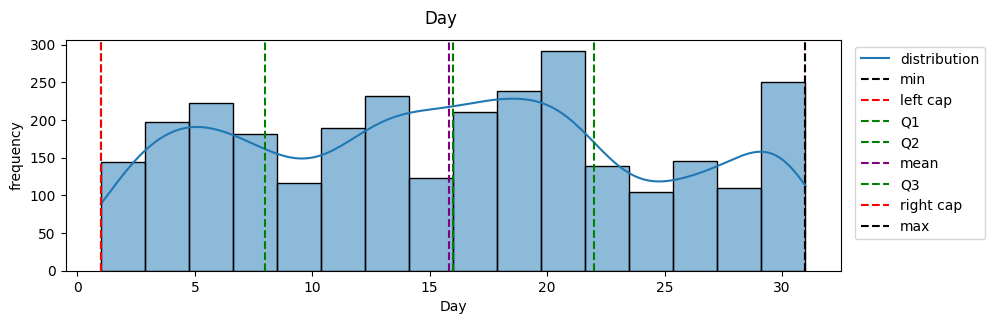

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,1,1,8.0,16.0,22.0,31,31,15.827003,30


PEOPLE WHO HAVE NOT SUBSCRIBED TO A TERM DEPOSIT:


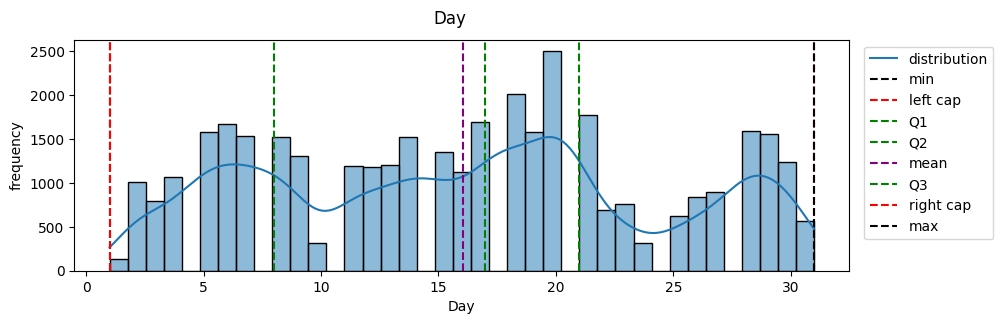

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,1,1,8.0,17.0,21.0,31,31,16.032072,20


In [17]:
print('PEOPLE WHO HAVE SUBSCRIBED TO A TERM DEPOSIT:')
plot_distribution_with_stats(df[subscribed_mask], 'day');

print('PEOPLE WHO HAVE NOT SUBSCRIBED TO A TERM DEPOSIT:')
plot_distribution_with_stats(df[~subscribed_mask], 'day');

For better appreciation of the two cases (subscribed and unsubscribed customers), two graphs were presented.

Day values are behaving as expected, in the range between 1-31. No particular pattern is observed for both cases.

##### Duration

We had seen before that the duration attribute had 0 values. Lets check in how many cases does this happen.

In [18]:
case_mask = df['duration'] == 0

print(f'0 seconds duration entries make up for {get_percent(df, case_mask, df, true_mask)}% of the data ({df[case_mask].shape[0]} entries)')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

0 seconds duration entries make up for 0.01% of the data (3 entries)
From those people 0.0% (0 entries) subscribed to a term deposit. They represent 0.0% from total.


Since there are only 3 entries that have contacts of 0 seconds of duration, we decided to leave them as they are. Lets plot the distribution:

In [19]:
aux = plot_distribution_with_stats(df, 'duration', graph=False);

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,0,0,100.0,175.0,313.0,632,4918,254.8243,124


In [23]:
print(f"Maximum contact duration was of {np.round(aux.loc[0, 'max']/60/60, 2)} hs")
print(f"Mean contact duration was of {np.round(aux.loc[0, 'mean']/60, 2)} min")
print(f"Mode contact duration was of {np.round(aux.loc[0, 'mode']/60, 2)} min")

Maximum contact duration was of 1.37 hs
Mean contact duration was of 4.25 min
Mode contact duration was of 2.07 min


Results show that the maximum contact duration was of aproximately 1.5 hours, even though this is a possible scenario, it belongs to the outliers of the distribuition; in other words, it belongs to exceptional cases. The mean contact duration is of about 4 minutes and in general, most calls have a duration of about 2 minutes.

The rest of the statistical information shows that there are upper bounds outliers; lets quantify how many and then plot the distribution graph eliminating the outliers to get a closer look at the distribution:

7.53% (3012 entries) of the data are upper bound outliers
From these cases 47.88% (1442 entries) subscribed to a term deposit. They represent 3.6% from total.


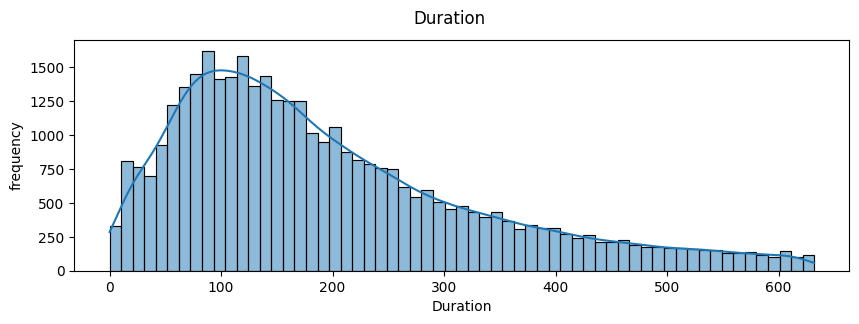

In [21]:
case_mask = df['duration'] >= aux.loc[0, 'right cap']

print(f'{get_percent(df, case_mask, df, true_mask)}% ({df[case_mask].shape[0]} entries) of the data are upper bound outliers')
print(f'From these cases {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

mask = (df['duration'] >= aux.loc[0, 'left cap']) & (df['duration'] <= aux.loc[0, 'right cap'])
plot_distribution_with_stats(df[mask], 'duration', lines=False);

Contact duration values are behaving as expected. A right / positive skewed distribution is observed with mean at 254 seconds.

##### Campaign

We had seen that the maximum value was further away from that of Q3. Lets plot the distribution:

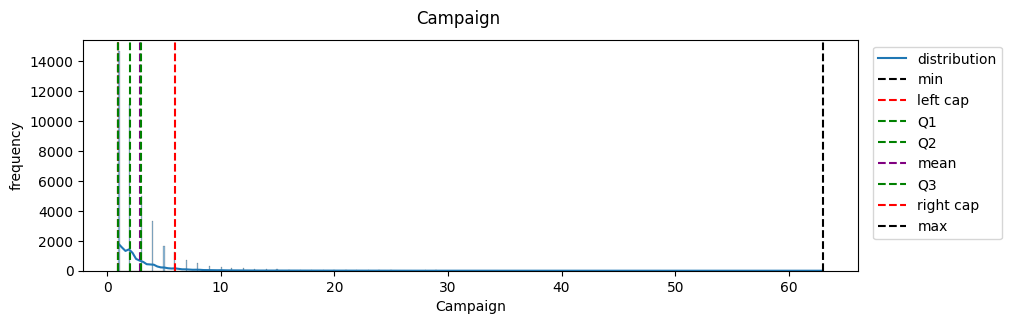

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,1,1,1.0,2.0,3.0,6,63,2.882175,1


In [20]:
aux = plot_distribution_with_stats(df, 'campaign');

Results show that the maximum amount of contacts performed during this campaign is of 63 instances. It also shows that there are upper bounds outliers; lets quantify how many:

In [21]:
case_mask = df['campaign'] >= aux.loc[0, 'right cap']

print(f'{get_percent(df, case_mask, df, true_mask)}% ({df[case_mask].shape[0]} entries) of the data are upper bound outliers')
print(f'From these cases {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

10.55% (4220 entries) of the data are upper bound outliers
From these cases 4.81% (203 entries) subscribed to a term deposit. They represent 0.51% from total.


To get a better look at the distribution lets eliminate the outliers.

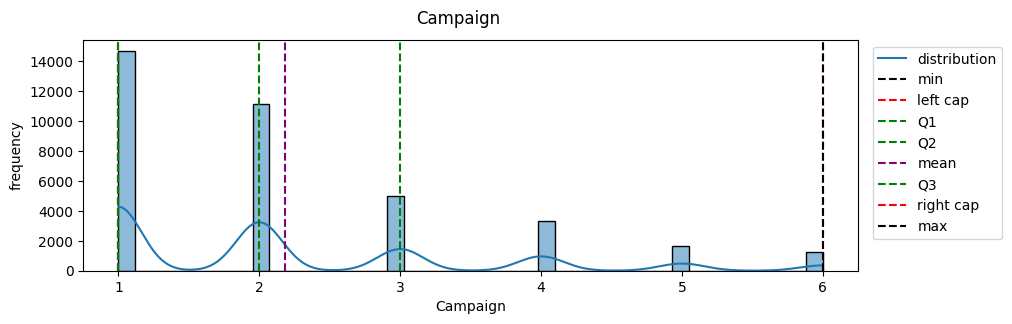

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,1,1,1.0,2.0,3.0,6,6,2.18061,1


In [22]:
mask = (df['campaign'] >= aux.loc[0, 'left cap']) & (df['campaign'] <= aux.loc[0, 'right cap'])
plot_distribution_with_stats(df[mask], 'campaign');

In [23]:
case_mask = mask

print(f'{get_percent(df, case_mask, df, true_mask)}% ({df[case_mask].shape[0]} entries) of the data have had between 1 and 6 contacts during this campaign')
print(f'From these cases {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

92.52% (37008 entries) of the data have had between 1 and 6 contacts during this campaign
From these cases 7.46% (2761 entries) subscribed to a term deposit. They represent 6.9% from total.


Contact duration values are behaving as expected. No particular pattern is observed for both cases.

#### Categorical attributes

According to the data description we can identify real categorical attributes and binary attributes:
- categorical: job, marital, education, contact, month
- binary: default, housing, loan

Lets start with the binary attributes:

##### Binary attributes

In [24]:
for col in ['default', 'housing', 'loan']:
    print()
    print(np.round(df[col].value_counts(normalize=True, dropna=False)*100, 2))


no     97.98
yes     2.02
Name: default, dtype: float64

yes    60.08
no     39.92
Name: housing, dtype: float64

no     82.68
yes    17.32
Name: loan, dtype: float64


We observe that we can easily start off by replacing this values with boolean data types.

In [25]:
df[['default', 'housing', 'loan']] = df[['default', 'housing', 'loan']].replace({'no': False, 'yes': True})

for col in ['default', 'housing', 'loan']:
    print()
    print(np.round(df[col].value_counts(normalize=True, dropna=False)*100, 2))


False    97.98
True      2.02
Name: default, dtype: float64

True     60.08
False    39.92
Name: housing, dtype: float64

False    82.68
True     17.32
Name: loan, dtype: float64


##### Real categorical attributes

**Job**

In [26]:
np.round(df['job'].value_counts(normalize=True, dropna=False)*100, 2)

blue-collar      23.46
management       20.42
technician       17.13
admin            11.21
services          9.78
retired           3.59
self-employed     3.54
entrepreneur      3.51
unemployed        2.76
housemaid         2.72
student           1.31
unknown           0.59
Name: job, dtype: float64

No null values are found and the only category that seems that would lead to unuseful information would be the `unkown` class.

In [27]:
case_mask = df['job'] == 'unknown'

print(f'Entries with `unkown` jobs make up for {get_percent(df, case_mask, df, true_mask)}% of the data ({df[case_mask].shape[0]} entries)')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

Entries with `unkown` jobs make up for 0.59% of the data (235 entries)
From those people 7.23% (17 entries) subscribed to a term deposit. They represent 0.04% from total.


# TODO unify classes?

**Marital status**

In [28]:
np.round(df['marital'].value_counts(normalize=True, dropna=False)*100, 2)

married     60.96
single      27.22
divorced    11.81
Name: marital, dtype: float64

**Education**

In [29]:
np.round(df['education'].value_counts(normalize=True, dropna=False)*100, 2)

secondary    52.48
tertiary     28.02
primary      15.68
unknown       3.83
Name: education, dtype: float64

No null values are found and the only category that seems that would lead to unuseful information would be the `unkown` class.

In [30]:
case_mask = df['education'] == 'unknown'

print(f'Entries with `unkown` education make up for {get_percent(df, case_mask, df, true_mask)}% of the data ({df[case_mask].shape[0]} entries)')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

Entries with `unkown` education make up for 3.83% of the data (1531 entries)
From those people 6.27% (96 entries) subscribed to a term deposit. They represent 0.24% from total.


**Contact communication type**

In [31]:
np.round(df['contact'].value_counts(normalize=True, dropna=False)*100, 2)

cellular     62.28
unknown      31.91
telephone     5.80
Name: contact, dtype: float64

No null values are found and the only category that seems that would lead to unuseful information would be the `unkown` class.

In [32]:
case_mask = df['contact'] == 'unknown'

print(f'Entries with `unkown` contact communication type make up for {get_percent(df, case_mask, df, true_mask)}% of the data ({df[case_mask].shape[0]} entries)')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

Entries with `unkown` contact communication type make up for 31.91% of the data (12765 entries)
From those people 3.89% (497 entries) subscribed to a term deposit. They represent 1.24% from total.


##### Month

In [33]:
np.round(df['month'].value_counts(normalize=True, dropna=False)*100, 2)

may    33.83
jul    15.95
aug    13.04
jun    11.84
nov     9.00
apr     6.80
feb     5.74
jan     2.94
mar     0.64
oct     0.20
dec     0.03
Name: month, dtype: float64

In this case months can be converted to their numerical version.

In [35]:
df['month'] = df['month'].replace({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 
    'jul': 7, 'aug': 8, 'oct': 10, 'nov': 11, 'dec': 12, 
})
np.round(df['month'].value_counts(normalize=True, dropna=False)*100, 2)

5     33.83
7     15.95
8     13.04
6     11.84
11     9.00
4      6.80
2      5.74
1      2.94
3      0.64
10     0.20
12     0.03
Name: month, dtype: float64